In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [105]:
def Find_ESS(lambda0):
    # find the ES=E[z] and ESS=E[zz^T]
    N, K = lambda0.shape
    ES = lambda0 
    ESS = lambda0.T @ lambda0 
    ESS = ESS - np.diag(np.diag(ESS)) + np.diag(np.sum(ES, axis=0))

    return ES, ESS


# def Find_lambda(X, mu, sigma, pie, lambda0):
#     N_, K = lambda0.shape
#     lambda_new = lambda0
#     diag_mu = np.diag(mu.T@mu).flatten()
#     for k in range(K):
#         x = (np.log(pie[:, k]/(1-pie[:, k]))
#                  + 1 / (sigma**2)
#                  * ((X-lambda_new@mu.T)@mu[:, k]
#                 +lambda_new[:, k]*diag_mu[k]
#                 - 0.5*diag_mu[k]
#                  )
#                  )
#         lambda_new[:, k] = 1/(1+np.exp(-x))
#     return lambda_new

def Find_Free_Energy(X, mu, sigma, pie, lambda0):
    # Compute the free energy
    N, D = X.shape # Number of samples and dimensionality
    _, K = lambda0.shape # Number of clusters

    # Regularize lambda0 to avoid numerical issues

    lambda0[lambda0 >= 1] = 1 - 1e-12
    lambda0[lambda0 <= 0] = 1e-12

    # Compute ES and ESS
    ES, ESS = Find_ESS(lambda0)

    # Free energy calculation
    F = - 0.5 * N * D * np.log(2 * np.pi * sigma**2)  # Constant term
    F -= 0.5 / sigma**2 * (
        np.trace(X.T @ X) +
        np.trace(mu.T @ mu @ ESS) -
        2 * np.trace(ES.T @ X @ mu)
    )  # Quadratic term
    F += np.sum(lambda0 * np.log(pie/lambda0) + (1 - lambda0) * np.log((1 - pie)/(1 - lambda0)))
      # Prior and entropy term

    return F

def EP(X, mu, sigma, pie, message0, maxsteps):
    # Dimensions
    N, D = X.shape
    _, K, _ = message0.shape

    # initialisation
    message = np.zeros_like(message0)
    Fval = -np.inf
    epsilon = 1e-10

    # single variable update f_i(s_i)
    f_i = np.zeros((N, K))
    diag_mu = np.diag(mu.T@mu).flatten()
    for n in range(N):
        f_i[n, :] = np.log(pie/(1-pie)) + 1/(sigma**2) * X[n, :]@mu - 1/(2*sigma**2) * diag_mu
    
    # pairwise variable update g_ij(s_i, s_j)
    for _ in range(maxsteps):
        for n in range(N):
            message_n = message0[:, :, n].copy() # KxK
            for i in range(K):
                for j in range(i+1, K):
                    alpha = 0.5 # damping parameter
                    # j to i
                    b_ij = -mu[:, i] @ mu[:, j]/(sigma**2)
                    nv_j = f_i[n, j] + np.sum(message_n[:, j]) - message_n[i, j]
                    message_ji = (np.exp(nv_j + b_ij) + 1)/(1 + np.exp(nv_j))
                    message_ji_new = np.log(message_ji)
                    # apply damping
                    message_n[j, i] = alpha*message_n[j, i] + (1-alpha)*message_ji_new

                    # i to j
                    b_ji = -mu[:, j] @ mu[:, i]/(sigma**2)
                    nv_i = f_i[n, i] + np.sum(message_n[:, i]) - message_n[j, i]
                    message_ij = (np.exp(nv_i + b_ji) + 1)/(1 + np.exp(nv_i))
                    message_ij_new = np.log(message_ij)
                    # apply damping
                    message_n[i, j] = alpha*message_n[i, j] + (1-alpha)*message_ij_new
            message[:, :, n] = message_n

        lambdas = np.zeros((N, K))
        for n in range(N):
            z = f_i[n, :] + np.sum(message[:, :, n], axis=0)
            lambdas[n, :] = 1/(1 + np.exp(-z))

        ES, ESS = Find_ESS(lambdas)

        lambdas[lambdas >= 1] = 1 - 1e-15
        lambdas[lambdas <= 0] = 1e-15
        F_new = Find_Free_Energy(X, mu, sigma, pie, lambdas)

        diff_message = np.max(np.abs(message - message0))
        if diff_message < epsilon:
            Fval = F_new
            break
        Fval = F_new
        message0 = message.copy()
    return lambdas, Fval, message







In [4]:
def m_step(X, ES, ESS):
    """
    mu, sigma, pie = MStep(X,ES,ESS)

    Inputs:
    -----------------
           X: shape (N, D) data matrix
          ES: shape (N, K) E_q[s]
         ESS: shape (K, K) sum over data points of E_q[ss'] (N, K, K)
                           if E_q[ss'] is provided, the sum over N is done for you.

    Outputs:
    --------
          mu: shape (D, K) matrix of means in p(y|{s_i},mu,sigma)
       sigma: shape (,)    standard deviation in same
         pie: shape (1, K) vector of parameters specifying generative distribution for s
    """
    N, D = X.shape
    if ES.shape[0] != N:
        raise TypeError('ES must have the same number of rows as X')
    K = ES.shape[1]
    if ESS.shape == (N, K, K):
        ESS = np.sum(ESS, axis=0)
    if ESS.shape != (K, K):
        raise TypeError('ESS must be square and have the same number of columns as ES')

    mu = np.dot(np.dot(np.linalg.inv(ESS), ES.T), X).T
    sigma = np.sqrt((np.trace(np.dot(X.T, X)) + np.trace(np.dot(np.dot(mu.T, mu), ESS))
                     - 2 * np.trace(np.dot(np.dot(ES.T, X), mu))) / (N * D))
    pie = np.mean(ES, axis=0, keepdims=True)
    
    return mu, sigma, pie

In [87]:
def LearnBinFactors(X, K, iterations):
    # dimensions
    N, D = X.shape
    F_list = []
    Fval = -np.inf
    epsilon = 1e-100
    maxsteps = 50
    # initialisation
    lambda0 = np.random.rand(N, K)
    ES, ESS = Find_ESS(lambda0)
    mu, sigma, pie = m_step(X, ES, ESS)
    message0 = np.random.rand(K, K, N)

    for n in range(N):
        message_n = message0[:, :, n]
        # zero diagonal
        np.fill_diagonal(message_n, 0)
        message0[:, :, n] = message_n

    for i in range(iterations):
        # E-step
        lambd, F_new, message = EP(X, mu, sigma, pie, message0, maxsteps)
        F_list.append(F_new)
        # M-step
        ES, ESS = Find_ESS(lambd)
        mu, sigma, pie = m_step(X, ES, ESS)
        F_list.append(F_new)
        print("Iteration number {} with free energy{:.4f}".format(i, F_new))
        if (F_new - Fval) < epsilon:
            break
        Fval = F_new
        message0 = message
    
    return mu, sigma, pie, lambd, F_list


In [6]:
def generate_feature_data(N=400, D=16, seed=0):



    np.random.seed(seed)

  # Define the basic shapes of the features

    m1 = [0, 0, 1, 0,
      0, 1, 1, 1,
      0, 0, 1, 0,
      0, 0, 0, 0]

    m2 = [0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0]

    m3 = [1, 1, 1, 1,
      0, 0, 0, 0,
      0, 0, 0, 0,
      0, 0, 0, 0]

    m4 = [1, 0, 0, 0,
      0, 1, 0, 0,
      0, 0, 1, 0,
      0, 0, 0, 1] 

    m5 = [0, 0, 0, 0,
      0, 0, 0, 0,
      1, 1, 0, 0,
      1, 1, 0, 0] 

    m6 = [1, 1, 1, 1,
      1, 0, 0, 1,
      1, 0, 0, 1,
      1, 1, 1, 1] 

    m7 = [0, 0, 0, 0,
      0, 1, 1, 0,
      0, 1, 1, 0,
      0, 0, 0, 0]

    m8 = [0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1]

    nfeat = 8 # number of features
    rr = 0.5 + np.random.rand(nfeat, 1) * 0.5 # weight of each feature between 0.5 and 1
    mut = np.array([rr[0] * m1, rr[1] * m2, rr[2] * m3, rr[3] * m4, rr[4] * m5,
                rr[5] * m6, rr[6] * m7, rr[7] * m8])
    s = np.random.rand(N, nfeat) < 0.3 # each feature occurs with prob 0.3 independently 

    # Generate Data - The Data is stored in Y

    Y = np.dot(s, mut) + np.random.randn(N, D) * 0.1 # some Gaussian noise is added 

    nrows = 13
    for k in range(16):
        plt.subplot(4, 4, k + 1)
        plt.imshow(np.reshape(Y[k], (4, 4)), cmap=plt.gray(), interpolation='none')
        plt.axis('off')

    plt.show()

    return Y


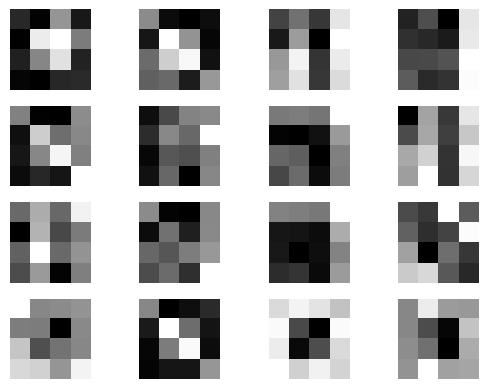

Iteration number 0 with free energy-4895.9669
Iteration number 1 with free energy-4355.0226
Iteration number 2 with free energy-4074.7028
Iteration number 3 with free energy-4011.6129
Iteration number 4 with free energy-3951.0286
Iteration number 5 with free energy-3907.6712
Iteration number 6 with free energy-3884.0111
Iteration number 7 with free energy-3869.7326
Iteration number 8 with free energy-3855.1527
Iteration number 9 with free energy-3835.4484
Iteration number 10 with free energy-3810.3097
Iteration number 11 with free energy-3781.9449
Iteration number 12 with free energy-3752.1694
Iteration number 13 with free energy-3721.3023
Iteration number 14 with free energy-3689.0521
Iteration number 15 with free energy-3655.3139
Iteration number 16 with free energy-3620.0483
Iteration number 17 with free energy-3582.8688
Iteration number 18 with free energy-3543.0704
Iteration number 19 with free energy-3499.7492
Iteration number 20 with free energy-3452.6733
Iteration number 21 wit

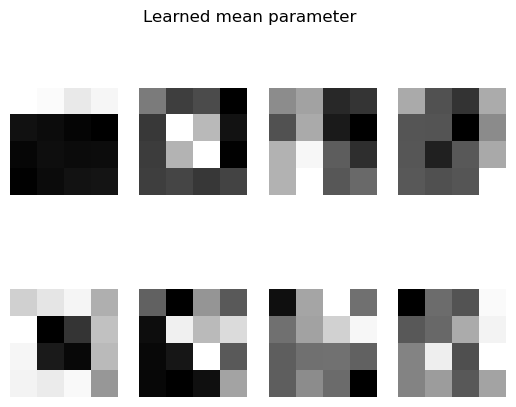

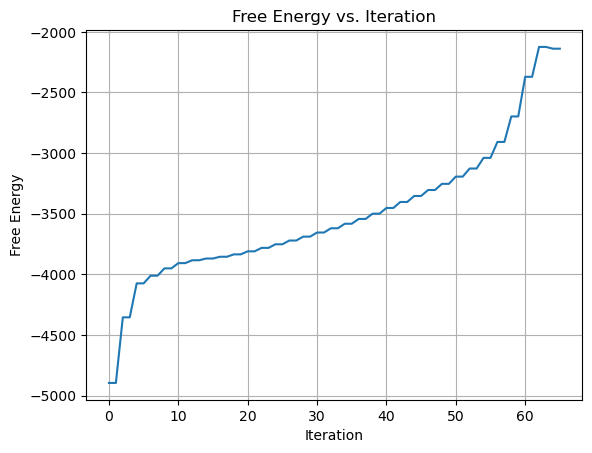

In [111]:
seed = 486
X = generate_feature_data(seed=seed)
K = 8
mu, sigma, pie, lambd, Fs= LearnBinFactors(X, K, 50)


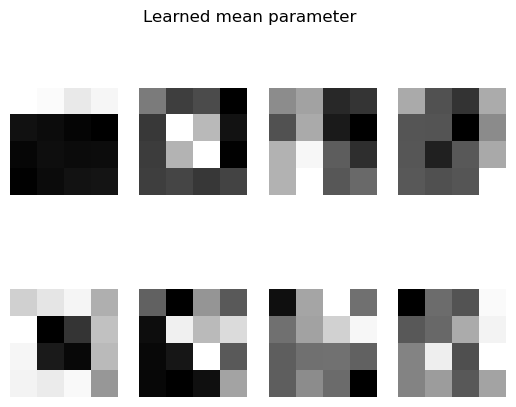

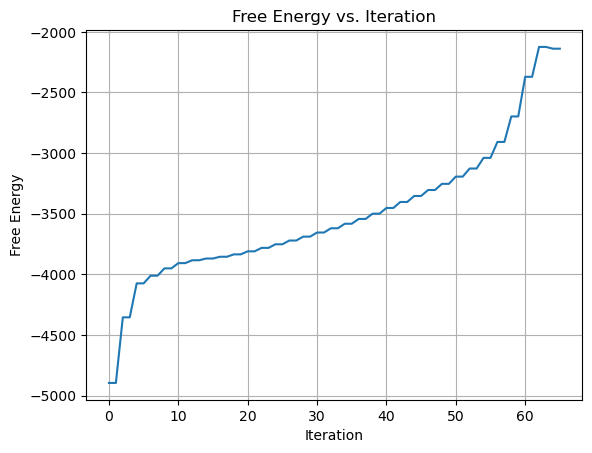

In [112]:

plt.figure()
for k in range(K):
    plt.subplot(int(K/4), int(K/2), k + 1)
    plt.imshow(np.reshape(mu[:, k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')
plt.suptitle("Learned mean parameter")
plt.savefig("LearnedMean_EP.png")
plt.show()

plt.figure()
plt.plot(Fs)
plt.xlabel("Iteration")
plt.ylabel("Free Energy")
plt.title("Free Energy vs. Iteration")
plt.grid()
plt.savefig("FreeEnergy_EP.png")
plt.show()

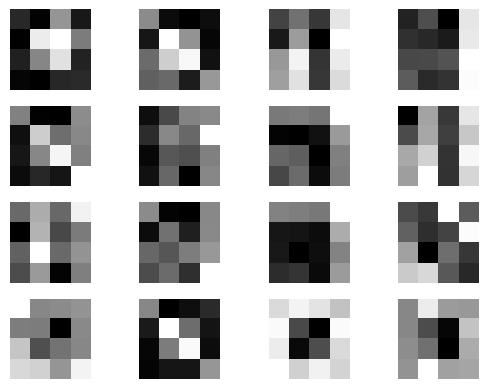

Iteration number 0 with free energy-5444.0101
Iteration number 1 with free energy-5079.1979
Iteration number 2 with free energy-4728.0030
Iteration number 3 with free energy-4483.8186
Iteration number 4 with free energy-4342.7733
Iteration number 5 with free energy-4189.0800
Iteration number 6 with free energy-4041.4443
Iteration number 7 with free energy-3874.0471
Iteration number 8 with free energy-3670.7127
Iteration number 9 with free energy-3455.6513
Iteration number 10 with free energy-3288.4363
Iteration number 11 with free energy-3174.3468
Iteration number 12 with free energy-3035.0064
Iteration number 13 with free energy-2803.6380
Iteration number 14 with free energy-2481.4028
Iteration number 15 with free energy-2269.1989
Iteration number 16 with free energy-2252.1484
Iteration number 17 with free energy-2157.2754
Iteration number 18 with free energy-2140.1115
Iteration number 19 with free energy-1944.8963
Iteration number 20 with free energy-1966.5811


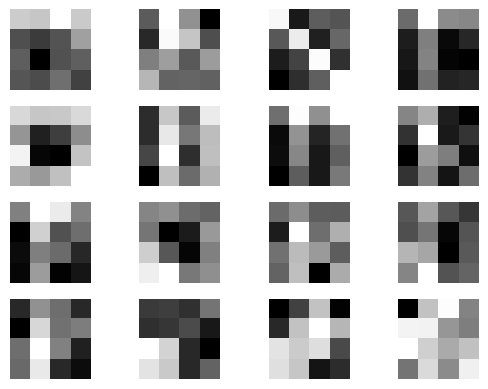

Iteration number 0 with free energy-5462.3404
Iteration number 1 with free energy-5079.2126
Iteration number 2 with free energy-4747.3742
Iteration number 3 with free energy-4487.8352
Iteration number 4 with free energy-4308.0698
Iteration number 5 with free energy-4041.3753
Iteration number 6 with free energy-3734.6081
Iteration number 7 with free energy-3445.5582
Iteration number 8 with free energy-3172.9793
Iteration number 9 with free energy-2943.4163
Iteration number 10 with free energy-2754.9041
Iteration number 11 with free energy-2489.3760
Iteration number 12 with free energy-2314.3919
Iteration number 13 with free energy-2279.9035
Iteration number 14 with free energy-2319.6571


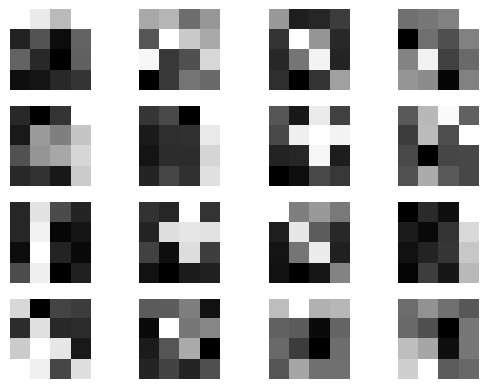

Iteration number 0 with free energy-5460.6131
Iteration number 1 with free energy-5062.2105
Iteration number 2 with free energy-4689.9889
Iteration number 3 with free energy-4441.0558
Iteration number 4 with free energy-4289.7423
Iteration number 5 with free energy-4116.9441
Iteration number 6 with free energy-3929.6419
Iteration number 7 with free energy-3727.9567
Iteration number 8 with free energy-3501.5048
Iteration number 9 with free energy-3231.9671
Iteration number 10 with free energy-2877.0279
Iteration number 11 with free energy-2613.2807
Iteration number 12 with free energy-2590.0122
Iteration number 13 with free energy-2752.1373


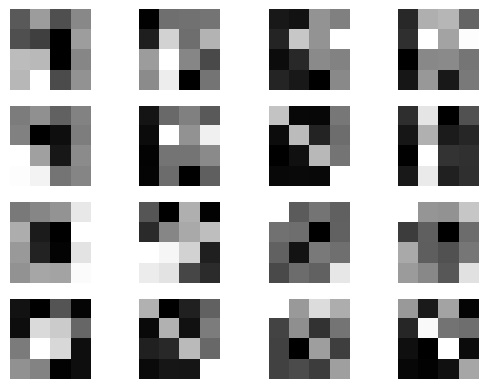

Iteration number 0 with free energy-5447.5350
Iteration number 1 with free energy-5121.4862
Iteration number 2 with free energy-4819.6927
Iteration number 3 with free energy-4393.1368
Iteration number 4 with free energy-4092.6148
Iteration number 5 with free energy-3789.4906
Iteration number 6 with free energy-3431.1754
Iteration number 7 with free energy-3060.1470
Iteration number 8 with free energy-2609.7117
Iteration number 9 with free energy-2189.6203
Iteration number 10 with free energy-2079.9707
Iteration number 11 with free energy-2177.1645


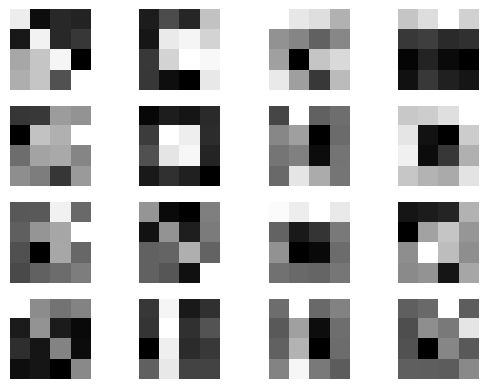

Iteration number 0 with free energy-5455.7818
Iteration number 1 with free energy-5109.6599
Iteration number 2 with free energy-4819.6232
Iteration number 3 with free energy-4574.6774
Iteration number 4 with free energy-4382.0962
Iteration number 5 with free energy-4271.4980
Iteration number 6 with free energy-4183.4873
Iteration number 7 with free energy-4110.7310
Iteration number 8 with free energy-4018.3543
Iteration number 9 with free energy-3888.0997
Iteration number 10 with free energy-3734.1548
Iteration number 11 with free energy-3530.1802
Iteration number 12 with free energy-3238.6390
Iteration number 13 with free energy-2928.6397
Iteration number 14 with free energy-2736.1968
Iteration number 15 with free energy-2569.1837
Iteration number 16 with free energy-2520.9667
Iteration number 17 with free energy-2485.9167
Iteration number 18 with free energy-2456.5134
Iteration number 19 with free energy-2370.1738
Iteration number 20 with free energy-2344.7491
Iteration number 21 wit

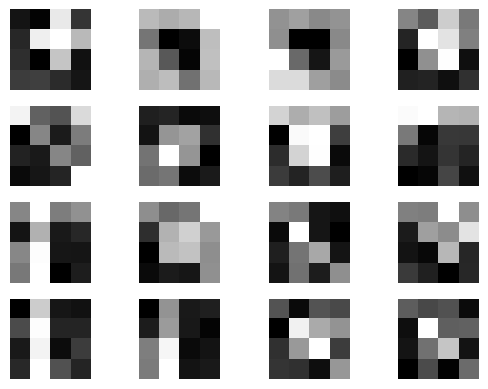

Iteration number 0 with free energy-5446.9415
Iteration number 1 with free energy-5045.3520
Iteration number 2 with free energy-4735.8361
Iteration number 3 with free energy-4514.4447
Iteration number 4 with free energy-4403.8309
Iteration number 5 with free energy-4318.7934
Iteration number 6 with free energy-4230.4092
Iteration number 7 with free energy-4161.7599
Iteration number 8 with free energy-4115.4158
Iteration number 9 with free energy-4076.3482
Iteration number 10 with free energy-4032.9012
Iteration number 11 with free energy-3979.9259
Iteration number 12 with free energy-3915.1004
Iteration number 13 with free energy-3843.0461
Iteration number 14 with free energy-3783.0982
Iteration number 15 with free energy-3754.6637
Iteration number 16 with free energy-3753.1436
Iteration number 17 with free energy-3764.2275


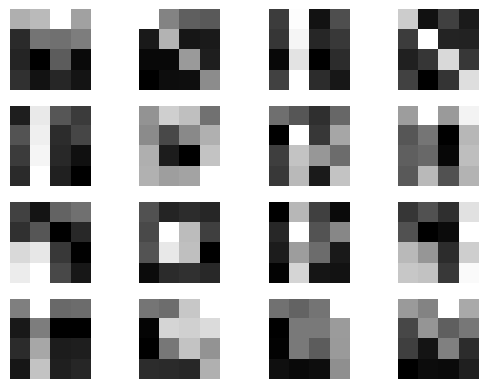

Iteration number 0 with free energy-5465.6019
Iteration number 1 with free energy-5070.8990
Iteration number 2 with free energy-4764.1761
Iteration number 3 with free energy-4545.6961
Iteration number 4 with free energy-4459.7867
Iteration number 5 with free energy-4419.0299
Iteration number 6 with free energy-4360.5509
Iteration number 7 with free energy-4271.8204
Iteration number 8 with free energy-4161.5017
Iteration number 9 with free energy-4047.2930
Iteration number 10 with free energy-3925.5692
Iteration number 11 with free energy-3789.1073
Iteration number 12 with free energy-3628.7269
Iteration number 13 with free energy-3439.6913
Iteration number 14 with free energy-3249.2908
Iteration number 15 with free energy-3075.5691
Iteration number 16 with free energy-2903.1030
Iteration number 17 with free energy-2619.0848
Iteration number 18 with free energy-2393.3452
Iteration number 19 with free energy-2353.0877
Iteration number 20 with free energy-2268.8696
Iteration number 21 wit

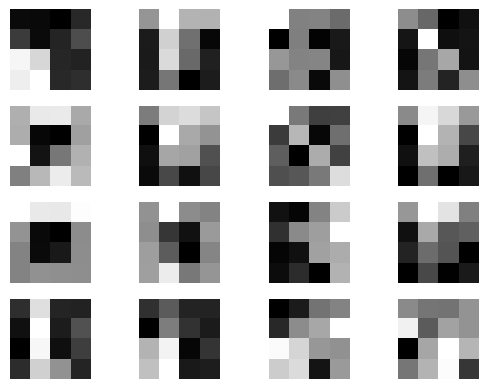

Iteration number 0 with free energy-5436.9901
Iteration number 1 with free energy-4963.4643
Iteration number 2 with free energy-4625.9939
Iteration number 3 with free energy-4367.8791
Iteration number 4 with free energy-4136.2479
Iteration number 5 with free energy-3955.1567
Iteration number 6 with free energy-3829.6668
Iteration number 7 with free energy-3624.9130
Iteration number 8 with free energy-3357.4608
Iteration number 9 with free energy-3242.6251
Iteration number 10 with free energy-3350.3286


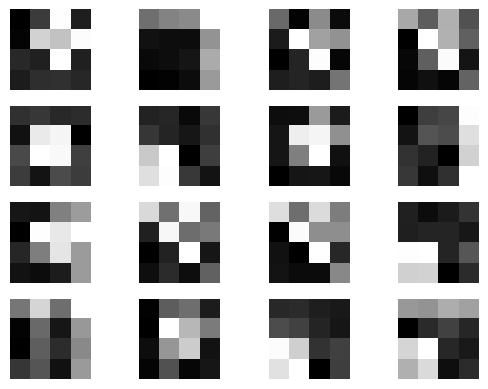

Iteration number 0 with free energy-5463.5875
Iteration number 1 with free energy-5015.3663
Iteration number 2 with free energy-4706.8037
Iteration number 3 with free energy-4466.4928
Iteration number 4 with free energy-4360.6660
Iteration number 5 with free energy-4282.6986
Iteration number 6 with free energy-4207.0341
Iteration number 7 with free energy-4116.3018
Iteration number 8 with free energy-3999.0411
Iteration number 9 with free energy-3870.4095
Iteration number 10 with free energy-3760.7576
Iteration number 11 with free energy-3676.2708
Iteration number 12 with free energy-3603.9641
Iteration number 13 with free energy-3526.5654
Iteration number 14 with free energy-3436.8923
Iteration number 15 with free energy-3323.6656
Iteration number 16 with free energy-3156.0724
Iteration number 17 with free energy-2880.0507
Iteration number 18 with free energy-2612.6492
Iteration number 19 with free energy-2426.5179
Iteration number 20 with free energy-2288.1664
Iteration number 21 wit

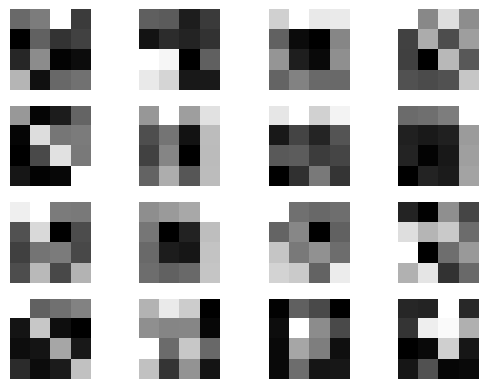

Iteration number 0 with free energy-5439.7754
Iteration number 1 with free energy-5100.5894
Iteration number 2 with free energy-4757.6595
Iteration number 3 with free energy-4421.1392
Iteration number 4 with free energy-4238.8712
Iteration number 5 with free energy-4103.5788
Iteration number 6 with free energy-3889.6907
Iteration number 7 with free energy-3557.4378
Iteration number 8 with free energy-3230.2664
Iteration number 9 with free energy-2964.0713
Iteration number 10 with free energy-2668.4770
Iteration number 11 with free energy-2742.6700


In [107]:
F_list = []
mu_list = []
seeds = []
for i in range(10):
    seed = np.random.randint(0, 1000)
    Y = generate_feature_data(seed = seed)
    mu, sigma, pie, lambd, Fs= LearnBinFactors(X, K, 50)
    F = Fs[-1]
    F_list.append(F)
    mu_list.append(mu)
    seeds.append(seed)

The best free energy is -1966.5811 with seed 486


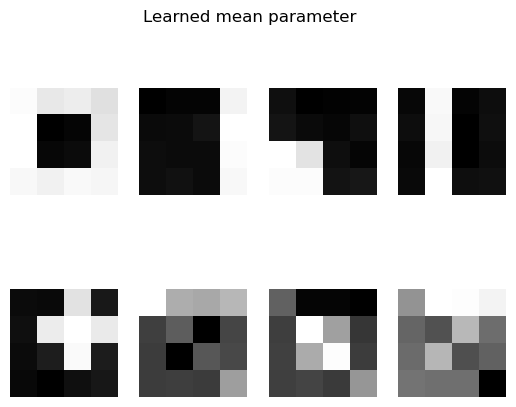

In [110]:
i = np.argmax(F_list)
mu = mu_list[i]
print("The best free energy is {:.4f} with seed {}".format(F_list[i], seeds[i]))
plt.figure()
for k in range(K):
    plt.subplot(int(K/4), int(K/2), k + 1)
    plt.imshow(np.reshape(mu[:, k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')
plt.suptitle("Learned mean parameter")
plt.savefig("best_mu_in_10_run_EP.png")
plt.show()